In [ ]:
# 변수의 shape, type, value 확인
def p(var,_name="") :
    if _name != "" : print(f'<<{_name}>>')
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}')

def pst(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}')

# LangChain Custom Agent 구현

In [ ]:
%%time
!pip install -q langchain langchain-openai pydantic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 19.1 MB/s eta 0:00:00
CPU times: user 1.74 s, sys: 861 ms, total: 2.6 s
Wall time: 8.73 s


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
import os
from google.colab import userdata

# OpenAI API 키는 필요시 설정 (이번 실습에서는 사용하지 않음)
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

**pydantic.BaseModel** : 데이터 검증과 직렬화 기능을 제공하는 base class   
> data 검증 : parameter의 type을 지정하여, 사후 문제 발생을 방지  
> 직렬화(Serialization): 저장, 전송을 위한 format으로 변환  
> Data type에 엄격하게 dataset 구조화 가능  



In [ ]:
import torch
from pydantic import BaseModel
from typing import List, Dict

# core/domain_model.py
class ProcessStep(BaseModel):
    name: str
    parameters: Dict[str, float]

class Wafer(BaseModel):
    id: str
    steps: List[ProcessStep]

# --- 예제 사용법 ---
# ProcessStep 객체 생성
exposure_step = ProcessStep(name="노광", parameters={"Dose (mJ/cm^2)": 15.5, "Focus (um)": -0.05})
etch_step = ProcessStep(name="식각", parameters={"RF_Power (W)": 500, "Pressure (mTorr)": 10})

# Wafer 객체 생성
wafer_01 = Wafer(id="W-20250612-001", steps=[exposure_step, etch_step])

# 생성된 객체 출력 (JSON 형태로)
print(wafer_01.model_dump_json(indent=2))

{
  "id": "W-20250612-001",
  "steps": [
    {
      "name": "노광",
      "parameters": {
        "Dose (mJ/cm^2)": 15.5,
        "Focus (um)": -0.05
      }
    },
    {
      "name": "식각",
      "parameters": {
        "RF_Power (W)": 500.0,
        "Pressure (mTorr)": 10.0
      }
    }
  ]
}


## 복잡한 Tool 구현  
### Files / DBMS와 작용하는 Tool 만들기  

### File 조회 Tool

In [ ]:
# tools/manual_tool.py

# 가상 매뉴얼 파일 생성
manual_content_text = """
# DUV 노광 공정 표준 운영 절차서 (SOP)
버전: 2.1

## 중요 파라미터
- **노광량 (Exposure Dose)**: 목표 CD(Critical Dimension)에 따라 20.0 ~ 35.5 mJ/cm^2 범위에서 설정한다.
- **초점 (Focus)**: 최적의 초점 값은 -0.05 um 이며, ±0.1 um 내에서 관리되어야 한다.
- **레진 두께**: 150 nm 를 기준으로 관리한다.
"""
with open("DUV_manual.txt", "w", encoding="utf-8") as f:
    f.write(manual_content_text)

print("'DUV_manual.txt' 파일이 생성되었습니다.")

# 파일을 읽는 함수(툴) 정의
def load_manual(path: str) -> str:
    """주어진 경로의 텍스트 파일을 읽어 전체 내용을 문자열로 반환합니다."""
    print(f"--- 툴 호출: load_manual (경로: {path}) ---")
    try:
        with open(path, 'r', encoding='utf-8') as f:
            return f.read()
    except FileNotFoundError:
        return f"오류: '{path}' 파일을 찾을 수 없습니다."

# 테스트 ---
manual_data = load_manual("DUV_manual.txt")
print("\n[매뉴얼 내용]")
print(manual_data)

'DUV_manual.txt' 파일이 생성되었습니다.
--- 툴 호출: load_manual (경로: DUV_manual.txt) ---

[매뉴얼 내용]

# DUV 노광 공정 표준 운영 절차서 (SOP)
버전: 2.1

## 중요 파라미터
- **노광량 (Exposure Dose)**: 목표 CD(Critical Dimension)에 따라 20.0 ~ 35.5 mJ/cm^2 범위에서 설정한다.
- **초점 (Focus)**: 최적의 초점 값은 -0.05 um 이며, ±0.1 um 내에서 관리되어야 한다.
- **레진 두께**: 150 nm 를 기준으로 관리한다.



### DB 조회 Tool

#### DB생성 및 Data 삽입

In [ ]:
# tools/db_tool.py
import sqlite3
import json

# DB 생성
db_path = 'process.db'
if os.path.exists(db_path):
    os.remove(db_path)

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# 테이블 생성
cursor.execute('''
CREATE TABLE process_data (
    step_name TEXT PRIMARY KEY,
    parameters TEXT
)
''')

# 데이터 삽입
# 파라미터 데이터를 JSON 문자열로 저장
exposure_params = json.dumps({"Dose (mJ/cm^2)": 25.0, "Focus (um)": -0.05, "Validated": "Yes"})
etch_params = json.dumps({"RF_Power (W)": 500, "Pressure (mTorr)": 10, "Validated": "Yes"})

cursor.execute("INSERT INTO process_data (step_name, parameters) VALUES (?, ?)", ('노광', exposure_params))
cursor.execute("INSERT INTO process_data (step_name, parameters) VALUES (?, ?)", ('식각', etch_params))

conn.commit()
conn.close()
print(f"'{db_path}' 데이터베이스가 생성 및 초기화되었습니다.")

'process.db' 데이터베이스가 생성 및 초기화되었습니다.


#### DB 조회 Tool

In [ ]:
# DB에서 데이터를 조회하는 함수(툴) 정의
def get_process_data(step_name: str) -> dict:
    """주어진 공정 단계 이름으로 DB에서 파라미터 데이터를 조회하여 딕셔너리로 반환합니다."""
    print(f"--- 툴 호출: get_process_data (공정명: {step_name}) ---")
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    try:
        cursor.execute('SELECT parameters FROM process_data WHERE step_name=?', (step_name,))
        result = cursor.fetchone()
        if result:
            # JSON 문자열을 파이썬 딕셔너리로 변환하여 반환
            return json.loads(result[0])
        else:
            return {"error": f"'{step_name}'에 해당하는 데이터를 찾을 수 없습니다."}
    finally:
        conn.close()

# --- 함수 테스트 ---
db_data = get_process_data("노광")
print("\n[DB 조회 결과]")
print(db_data)

--- 툴 호출: get_process_data (공정명: 노광) ---

[DB 조회 결과]
{'Dose (mJ/cm^2)': 25.0, 'Focus (um)': -0.05, 'Validated': 'Yes'}


## Agent Pipeline Customizing  
### Plan-and-Execute 파이프라인을 직접 구현

In [ ]:
import ast
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

# LLM 초기화 (Planner 역할)
llm = ChatOpenAI(model="gpt-4o", temperature=0)

## '계획' 생성 함수 (LLM 활용)
# 사용자의 복잡한 쿼리를 분석하여, 실행 가능한 단계의 리스트 생성
def plan(query: str, llm_instance: ChatOpenAI) -> list[str]:
    """사용자의 복잡한 쿼리를 분석하여, 실행 가능한 단계의 리스트를 생성합니다."""
    print("--- 'plan' 함수 호출 ---")

    prompt = PromptTemplate.from_template("""
당신은 사용자의 요청을 분석하여, 아래에 명시된 도구를 사용한 단계별 실행 계획을 생성하는 전문 플래너입니다.
계획은 반드시 파이썬 리스트(list) 형식의 문자열로만 응답해야 합니다.

# 사용 가능한 도구 명세:
1. `LOAD_MANUAL:파일경로` : 지정된 경로의 매뉴얼 파일을 읽습니다. 예: `LOAD_MANUAL:DUV_manual.txt`
2. `DB_QUERY:공정명` : 지정된 공정명의 데이터를 데이터베이스에서 조회합니다. 예: `DB_QUERY:노광`

# 요청: {query}
# 계획:
""")

    planner_chain = prompt | llm
    response_content = planner_chain.invoke({"query": query}).content

    print(f"LLM이 생성한 계획 (원본 문자열):\n{response_content}")

    # --- LLM 응답에서 Markdown 코드 블록 제거 ---
    cleaned_content = response_content.strip()
    if cleaned_content.startswith("```python"):
        cleaned_content = cleaned_content[len("```python"):].strip()
    if cleaned_content.startswith("```"):
        cleaned_content = cleaned_content[len("```"):].strip()
    if cleaned_content.endswith("```"):
        cleaned_content = cleaned_content[:-len("```")].strip()
    # ----------------------------------------------------

    try:
        plan_list = ast.literal_eval(cleaned_content)
        if isinstance(plan_list, list):
            return plan_list
        else:
            return [f"Error: LLM이 리스트 형식이 아닌 응답을 생성했습니다 - {cleaned_content}"]
    except (ValueError, SyntaxError):
        return [f"Error: LLM 응답을 파싱할 수 없습니다 - {cleaned_content}"]


## '실행' 함수 (도구 호출)
# 생성된 계획 리스트를 받아, 각 단계를 순차적으로 실행하고 결과를 반환
def execute(plan_steps: List[str]) -> List[str]:
    print("\n--- 'execute' 함수 호출 ---")
    results = []
    for step in plan_steps:
        if step.startswith('LOAD_MANUAL:'):
            # 'LOAD_MANUAL:DUV_manual.txt' -> 'DUV_manual.txt'
            _, path = step.split(':', 1)
            results.append(load_manual(path.strip()))
        elif step.startswith('DB_QUERY:'):
            _, name = step.split(':', 1)
            results.append(str(get_process_data(name.strip())))
        elif step.startswith('Error:'):
            results.append(step)
        else:
            results.append(f"알 수 없는 단계입니다: {step}")
    return results

In [ ]:
## 파이프라인 테스트 (간단한 쿼리) ---
simple_query = "DUV 공정 매뉴얼을 읽어줘."

# 계획 수립
planned_steps = plan(simple_query, llm)
print(f"\n생성된 최종 계획 (리스트): {planned_steps}")

# 계획 실행
execution_results = execute(planned_steps)

# 결과 출력
print("\n[최종 실행 결과]")
for result in execution_results:
    print(result)

--- 'plan' 함수 호출 ---
LLM이 생성한 계획 (원본 문자열):
```python
["LOAD_MANUAL:DUV_manual.txt"]
```

생성된 최종 계획 (리스트): ['LOAD_MANUAL:DUV_manual.txt']

--- 'execute' 함수 호출 ---
--- 툴 호출: load_manual (경로: DUV_manual.txt) ---

[최종 실행 결과]

# DUV 노광 공정 표준 운영 절차서 (SOP)
버전: 2.1

## 중요 파라미터
- **노광량 (Exposure Dose)**: 목표 CD(Critical Dimension)에 따라 20.0 ~ 35.5 mJ/cm^2 범위에서 설정한다.
- **초점 (Focus)**: 최적의 초점 값은 -0.05 um 이며, ±0.1 um 내에서 관리되어야 한다.
- **레진 두께**: 150 nm 를 기준으로 관리한다.



In [ ]:
## plan 함수를 과제에 맞게 개선합니다.
#  복합 쿼리를 분석하여, 여러 단계의 실행 계획 리스트를 생성

def plan_advanced(query: str, llm_instance: ChatOpenAI) -> List[str]:
    print("--- 'plan_advanced' 함수 호출 ---")

    # 프롬프트에 구체적인 예시(few-shot)를 추가하여 LLM의 계획 수립 능력을 향상시킵니다.
    prompt = PromptTemplate.from_template("""
당신은 사용자의 요청을 분석하여, 아래에 명시된 도구를 사용한 단계별 실행 계획을 생성하는 전문 플래너입니다.
계획은 반드시 파이썬 리스트(list) 형식의 문자열로만 응답해야 합니다.

# 사용 가능한 도구 명세:
1. `LOAD_MANUAL:파일경로` : 지정된 경로의 매뉴얼 파일을 읽습니다. 예: `LOAD_MANUAL:DUV_manual.txt`
2. `DB_QUERY:공정명` : 지정된 공정명의 데이터를 데이터베이스에서 조회합니다. 예: `DB_QUERY:노광`

---
# 예시 1
요청: 식각 공정 데이터를 DB에서 조회해줘.
계획: ['DB_QUERY:식각']

# 예시 2
요청: DUV 공정 매뉴얼의 내용을 알려줘.
계획: ['LOAD_MANUAL:DUV_manual.txt']

# 예시 3
요청: 노광 파라미터를 매뉴얼에서 읽고, DB로 검증해줘.
계획: ['LOAD_MANUAL:DUV_manual.txt', 'DB_QUERY:노광']
---

# 실제 요청: {query}
# 계획:
""")

    planner_chain = prompt | llm
    response_content = planner_chain.invoke({"query": query}).content

    print(f"LLM이 생성한 계획 (문자열):\n{response_content}")

    try:
        plan_list = ast.literal_eval(response_content)
        if isinstance(plan_list, list):
            return plan_list
        else:
            return [f"Error: LLM이 리스트 형식이 아닌 응답을 생성했습니다 - {response_content}"]
    except (ValueError, SyntaxError):
        return [f"Error: LLM 응답을 파싱할 수 없습니다 - {response_content}"]

In [ ]:
# --- 검증 ---
# 검증용 복합 쿼리 정의
complex_query = "노광 파라미터를 매뉴얼에서 읽고, DB로 검증해줘"

# plan_advanced 함수로 계획 수립
advanced_planned_steps = plan_advanced(complex_query, llm)
print(f"\n생성된 최종 계획 (리스트): {advanced_planned_steps}")

# 기존 execute 함수로 계획 실행
final_execution_results = execute(advanced_planned_steps)

# 최종 결과 출력
print("\n[최종 실행 결과]")
# 각 단계의 결과를 구분하여 출력
for i, result in enumerate(final_execution_results):
    print(f"\n--- 결과 {i+1} ---")
    print(result)

--- 'plan_advanced' 함수 호출 ---
LLM이 생성한 계획 (문자열):
['LOAD_MANUAL:DUV_manual.txt', 'DB_QUERY:노광']

생성된 최종 계획 (리스트): ['LOAD_MANUAL:DUV_manual.txt', 'DB_QUERY:노광']

--- 'execute' 함수 호출 ---
--- 툴 호출: load_manual (경로: DUV_manual.txt) ---
--- 툴 호출: get_process_data (공정명: 노광) ---

[최종 실행 결과]

--- 결과 1 ---

# DUV 노광 공정 표준 운영 절차서 (SOP)
버전: 2.1

## 중요 파라미터
- **노광량 (Exposure Dose)**: 목표 CD(Critical Dimension)에 따라 20.0 ~ 35.5 mJ/cm^2 범위에서 설정한다.
- **초점 (Focus)**: 최적의 초점 값은 -0.05 um 이며, ±0.1 um 내에서 관리되어야 한다.
- **레진 두께**: 150 nm 를 기준으로 관리한다.


--- 결과 2 ---
{'Dose (mJ/cm^2)': 25.0, 'Focus (um)': -0.05, 'Validated': 'Yes'}


# 참고: Pydantic 기본 기능

In [ ]:
## 자동으로 타입 검증 수행

from pydantic import BaseModel

class User(BaseModel):  # BaseModel 상속
    name: str
    age: int

# 자동으로 타입 검증 수행
user = User(name="김철수", age="25")  # age: str → int 자동 변환
user = User(name="김철수", age="abc")  # ❌ 오류 발생

In [ ]:
## data 직력화 / 역직렬화

class Product(BaseModel):
    name: str
    price: float

# JSON → Python 객체 (신버전)
json_data = '{"name": "반도체칩", "price": 1000.50}'
product = Product.model_validate_json(json_data)

p(product,'product')
print("="*10)

# Python 객체 → JSON (신버전)
print(product.model_dump_json())
print("="*10)

# Python 객체 → dict (신버전)
print(product.model_dump())
print("="*10)

<<product>>
Type: <class '__main__.Product'>
Values: name='반도체칩' price=1000.5
{"name":"반도체칩","price":1000.5}
{'name': '반도체칩', 'price': 1000.5}


In [ ]:
## 주요 methods

class WaferData(BaseModel):
    wafer_id: str
    temperature: float

data = WaferData(wafer_id="W001", temperature=850.5)

# BaseModel이 제공하는 메서드들
print(data.model_dump_json())      # JSON 문자열로 변환
print(data.model_dump())           # 딕셔너리로 변환
print(data.model_json_schema())    # JSON 스키마 생성
print(data.model_copy())           # 객체 복사

{"wafer_id":"W001","temperature":850.5}
{'wafer_id': 'W001', 'temperature': 850.5}
{'properties': {'wafer_id': {'title': 'Wafer Id', 'type': 'string'}, 'temperature': {'title': 'Temperature', 'type': 'number'}}, 'required': ['wafer_id', 'temperature'], 'title': 'WaferData', 'type': 'object'}
wafer_id='W001' temperature=850.5


In [ ]:
## 추가적인 동작 최적화

class StrictModel(BaseModel):
    class Config:
        # BaseModel 동작 방식 커스터마이징
        validate_assignment = True    # 할당 시에도 검증
        extra = "forbid"              # 추가 필드 금지

    value: int

model = StrictModel(value=10)
model.value = "20"                    # 재할당 시에도 타입 검증 수행

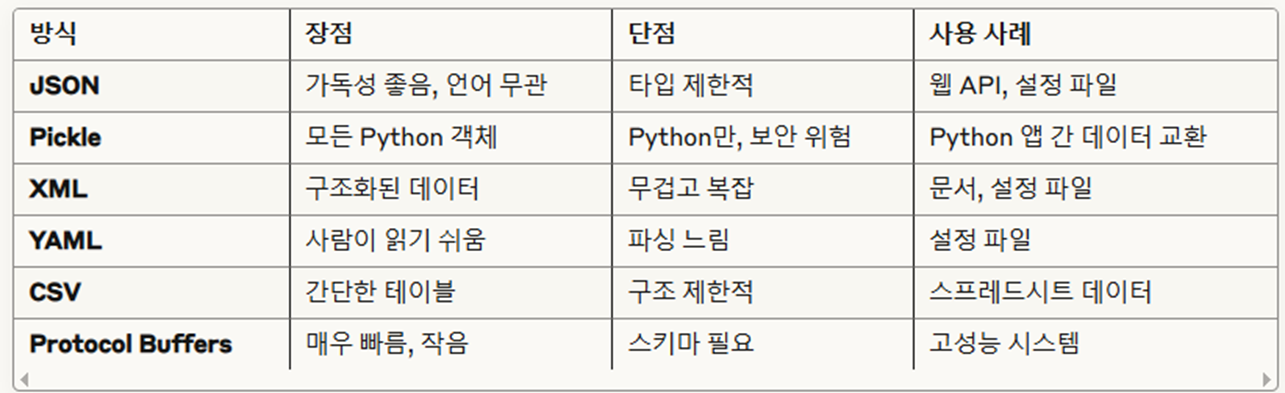

# 참고: LCEL 기본 기능  
## LCEL(LangChain Expression Language)은 LangChain에서 체인을 쉽고 직관적으로 구축할 수 있는 선언적 언어
> 가독성 향상  
다양한 Chain 구성  
간단한 병렬처리

In [ ]:
## 파이프라인 연산자 | 사용으로 가독성 향상, 직관적
# chain = input → prompt → llm → parser → output

from langchain.schema.runnable import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser

prompt = ChatPromptTemplate.from_template("""
다음 컨텍스트를 바탕으로 질문에 답하세요:
{context}

질문: {question}
""")

# LCEL 체인 구성
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

result = chain.invoke("반도체 공정에 대해 설명해줘")

In [ ]:
## 체인을 쉽게 결합, 재사용으로 확장

basic_chain = prompt | llm
enhanced_chain = basic_chain | StrOutputParser()
rag_chain = {"context": retriever, "question": RunnablePassthrough()} | enhanced_chain

In [ ]:
## 여러개의 체인이 병렬로 동작 가능, agent가 여러개 일때
from langchain.schema.runnable import RunnableParallel

# 여러 작업을 병렬로 실행
parallel_chain = RunnableParallel({
    "summary": summarize_chain,
    "translation": translate_chain,
    "sentiment": sentiment_chain
})

**Rag Chain 구성 예**

In [ ]:
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 1. 벡터스토어 준비
vectorstore = FAISS.from_texts(
    ["반도체 제조 공정...", "웨이퍼 처리 단계..."],
    OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

# 2. 프롬프트 템플릿
prompt = ChatPromptTemplate.from_template("""
반도체 전문가로서 다음 정보를 바탕으로 답변하세요:

참고 자료:
{context}

질문: {question}

전문적이고 정확한 답변을 제공해주세요.
""")

# 3. LCEL로 체인 구성
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
)

# 4. 실행
answer = rag_chain.invoke("CMOS 공정의 주요 단계는?")

In [ ]:
## 조건부 실행

from langchain.schema.runnable import RunnableBranch

# 질문 유형에 따라 다른 체인 실행
conditional_chain = RunnableBranch(
    (lambda x: "기술" in x["question"], technical_chain),
    (lambda x: "가격" in x["question"], pricing_chain),
    general_chain  # 기본값
)

In [ ]:
## 중간 결과 추가 조작

def format_context(docs):
    return "\n\n".join([doc.page_content for doc in docs])

chain = (
    {"context": retriever | format_context, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
## error 처리 : 메인 체인이 실패했을 때 대체 체인을 순차적으로 실행

from langchain.schema.runnable import RunnableWithFallbacks

# 메인 체인이 실패하면 백업 체인 실행
robust_chain = RunnableWithFallbacks(
    main_chain,
    fallbacks=[backup_chain, simple_chain]
)